In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

In [2]:
!pip install efficientnet_pytorch

/home/jh20/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/jh20/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install --upgrade pip

/home/jh20/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/jh20/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2


In [2]:
pet_df = pd.read_csv("/home/jh20/Data/pet/pet_df.csv")

In [3]:
pet_df.drop_duplicates(['mission-id'])[['mission-id','breed']].groupby('breed').count()

,mission-id
breed,
CHI,31
DRI,38
ETC,163
GOL,8
JIN,6
KOR,6
MAL,168
MIX,50
PER,3


In [4]:
MAL_df = pet_df[pet_df['breed']=='MAL']

In [5]:
MAL_df = MAL_df.loc[~MAL_df['body-part'].isin([1,2,13,14,15,16,17,18,19,20]),:]

In [6]:
MAL_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,environment,defecation,food-amount,snack-amount,food-kind,image-id,label,points,shape,part
141,A,10,10_000142,3,MAL,7.0,SS,CM,3.39,20.0,...,1,1,1.0,0.00,1,A_10_MAL_CM_20221019_10_000142_03.jpg,전신,"[[1091, 699], [3738, 2838]]",Bounding Box,좌측면중앙
142,A,10,10_000142,3,MAL,7.0,SS,CM,3.39,20.0,...,1,1,1.0,0.00,1,A_10_MAL_CM_20221019_10_000142_10.jpg,전신,"[[915, 849], [2797, 3100]]",Bounding Box,우측면우45도
143,A,10,10_000142,3,MAL,7.0,SS,CM,3.39,20.0,...,1,1,1.0,0.00,1,A_10_MAL_CM_20221019_10_000142_05.jpg,전신,"[[440, 334], [2332, 2699]]",Bounding Box,좌측면우45도
144,A,10,10_000142,3,MAL,7.0,SS,CM,3.39,20.0,...,1,1,1.0,0.00,1,A_10_MAL_CM_20221019_10_000142_12.jpg,전신,"[[912, 982], [3458, 2961]]",Bounding Box,우측면하45도
148,A,10,10_000142,3,MAL,7.0,SS,CM,3.39,20.0,...,1,1,1.0,0.00,1,A_10_MAL_CM_20221019_10_000142_04.jpg,전신,"[[627, 963], [2976, 3285]]",Bounding Box,좌측면좌45도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12531,A,10,10_101469,9,MAL,3.5,SS,IM,3.86,25.0,...,1,1,0.3,9.99,2,A_10_MAL_IM_20221213_10_101469_03.jpg,전신,"[[268, 284], [2564, 1531]]",Bounding Box,좌측면중앙
12532,A,10,10_101469,9,MAL,3.5,SS,IM,3.86,25.0,...,1,1,0.3,9.99,2,A_10_MAL_IM_20221213_10_101469_10.jpg,전신,"[[778, 233], [2214, 1529]]",Bounding Box,우측면우45도
12534,A,10,10_101469,9,MAL,3.5,SS,IM,3.86,25.0,...,1,1,0.3,9.99,2,A_10_MAL_IM_20221213_10_101469_05.jpg,전신,"[[612, 163], [2248, 1563]]",Bounding Box,좌측면우45도
12535,A,10,10_101469,9,MAL,3.5,SS,IM,3.86,25.0,...,1,1,0.3,9.99,2,A_10_MAL_IM_20221213_10_101469_11.jpg,전신,"[[147, 412], [2472, 1531]]",Bounding Box,우측면상45도


In [38]:
data_subdf1 = MAL_df[['mission-id','fat']]
data_subdf1.drop_duplicates(inplace=True)
data_subdf1

KeyError: "['fat'] not in index"

In [8]:
data_subdf1.BCS.value_counts()

5    59
4    39
6    31
3    24
7     6
2     4
9     2
8     1
Name: BCS, dtype: int64

In [9]:
data_subdf2 = MAL_df[['mission-id','BCS','image-id']]
data_subdf2.drop_duplicates(inplace=True)
data_subdf2

/home/jh20/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,mission-id,BCS,image-id
141,10_000142,5,A_10_MAL_CM_20221019_10_000142_03.jpg
142,10_000142,5,A_10_MAL_CM_20221019_10_000142_10.jpg
143,10_000142,5,A_10_MAL_CM_20221019_10_000142_05.jpg
144,10_000142,5,A_10_MAL_CM_20221019_10_000142_12.jpg
148,10_000142,5,A_10_MAL_CM_20221019_10_000142_04.jpg
...,...,...,...
12531,10_101469,6,A_10_MAL_IM_20221213_10_101469_03.jpg
12532,10_101469,6,A_10_MAL_IM_20221213_10_101469_10.jpg
12534,10_101469,6,A_10_MAL_IM_20221213_10_101469_05.jpg
12535,10_101469,6,A_10_MAL_IM_20221213_10_101469_11.jpg


In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(data_subdf1['mission-id'],data_subdf1.BCS,test_size=0.3,random_state=42)

In [11]:
x_train

10133    10_001526
7028     10_001159
815      10_000325
5570     10_001070
9614     10_001495
           ...    
6041     10_001094
7890     10_001225
1307     10_000388
6914     10_001152
7720     10_001216
Name: mission-id, Length: 116, dtype: object

In [12]:
y_train.value_counts()

5    38
4    29
6    20
3    19
7     5
2     3
9     1
8     1
Name: BCS, dtype: int64

In [13]:
y_valid.value_counts()

5    21
6    11
4    10
3     5
7     1
9     1
2     1
Name: BCS, dtype: int64

In [14]:
data_dir = '/home/jh20/Data/pet/alldata/'

In [15]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [16]:
class TorchvisionDataset(Dataset):
    def __init__(self, data_dir, x, y ,df, transform=None, cutout=None):
        self.data_dir = data_dir
        self.transform = transform
        self.cutout = cutout
        
#         all_data = glob.glob(self.file_path + '*.jpg')
        
#         all_file_lst = []
#         for i in all_data:
#             id_ = i.split('/')[-1].split('.')[0][-12:-3]
#             body_part = i.split('/')[-1].split('.')[0][-2:]
#             if (id_ in list(x)) and (body_part not in ['01','02','13','14','15','16','17','18','19','20']):
#                 all_file_lst.append(i)
        
        file_paths=[]
        labels=[]
        for (i,j,k,l) in df.itertuples():
            if j in list(x):
                file_paths.append(l)
                labels.append(k-1)
            
                
#         label_dic = {}       
#         for i,j in zip(x,y):
#             label_dic[i] =j
            
        
                

        
        
#         file_paths=[]
#         labels=[]
#         for file in all_file_lst:
#             id_ = file.split('/')[-1].split('.')[0][-12:-3]
#             labels.append(label_dic[id_]-1)
#             file_paths.append(file)
            
            
        self.file_paths = file_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file = self.file_paths[idx]
        
        file_path = data_dir + file
        
        # Read an image with PIL
        image = Image.open(file_path)
        

        if self.transform:
            image = self.transform(image)
            
        if self.cutout:
            image = self.cutout(image)

        return image, label , file_path

In [17]:
train_transforms = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(299),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(300),  # 사이즈 변경
        transforms.CenterCrop(299),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

cutout = Cutout(1,70)

In [18]:
train_dataset = TorchvisionDataset(data_dir,x_train,y_train,data_subdf2,train_transforms,cutout)

In [19]:
train_dataset[0]

(tensor([[[-0.7308, -0.7308, -0.7137,  ...,  0.6906,  0.6906,  0.6906],
          [-0.7137, -0.7308, -0.7137,  ...,  0.6906,  0.6906,  0.6906],
          [-0.7308, -0.7308, -0.7137,  ...,  0.6906,  0.6906,  0.6734],
          ...,
          [ 1.5810,  1.5982,  1.6324,  ...,  1.4954,  1.4954,  1.5125],
          [ 1.6153,  1.6324,  1.6495,  ...,  1.5468,  1.5468,  1.5125],
          [ 1.6495,  1.6495,  1.6667,  ...,  1.5639,  1.5639,  1.5468]],
 
         [[-0.6702, -0.6702, -0.6527,  ...,  0.8704,  0.8704,  0.8704],
          [-0.6527, -0.6702, -0.6527,  ...,  0.8704,  0.8704,  0.8704],
          [-0.6702, -0.6702, -0.6527,  ...,  0.8704,  0.8704,  0.8529],
          ...,
          [ 1.7458,  1.7633,  1.7983,  ...,  1.6583,  1.6583,  1.6758],
          [ 1.7808,  1.7983,  1.8158,  ...,  1.7108,  1.7108,  1.6758],
          [ 1.8158,  1.8158,  1.8333,  ...,  1.7283,  1.7283,  1.7108]],
 
         [[-0.5670, -0.5321, -0.5321,  ...,  1.0365,  1.0365,  1.0365],
          [-0.5495, -0.5495,

In [20]:
len(train_dataset)

993

In [21]:
valid_dataset = TorchvisionDataset(data_dir,x_valid,y_valid,data_subdf2,valid_transforms)

In [22]:
len(valid_dataset)

397

In [23]:
valid_dataset[0]

(tensor([[[-0.0458, -0.3883, -0.3027,  ..., -0.7308, -0.7308, -0.7308],
          [-0.6281, -0.7650, -0.7308,  ..., -0.7308, -0.7137, -0.7137],
          [-1.0904, -1.1589, -1.0733,  ..., -0.7137, -0.6965, -0.6965],
          ...,
          [ 1.2899,  1.2728,  1.2214,  ...,  0.9303,  0.9132,  0.9303],
          [ 1.2557,  1.2728,  1.2557,  ...,  0.9646,  0.9303,  0.9132],
          [ 1.2728,  1.2899,  1.2728,  ...,  0.9817,  0.9646,  0.9303]],
 
         [[ 0.0126, -0.4776, -0.4426,  ..., -0.7052, -0.7052, -0.7052],
          [-0.6527, -0.8627, -0.8452,  ..., -0.7052, -0.6877, -0.6877],
          [-1.1429, -1.2479, -1.1604,  ..., -0.6877, -0.6702, -0.6702],
          ...,
          [ 1.5007,  1.5007,  1.5007,  ...,  1.1331,  1.1155,  1.1331],
          [ 1.4832,  1.4832,  1.5007,  ...,  1.1506,  1.1155,  1.1155],
          [ 1.5007,  1.5182,  1.5007,  ...,  1.1331,  1.1331,  1.1155]],
 
         [[ 0.1651, -0.4798, -0.4973,  ..., -0.5321, -0.5321, -0.5321],
          [-0.5670, -0.8633,

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=4,
                                             shuffle=True, num_workers=64,drop_last=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=8,
                                             shuffle=True, num_workers=4,drop_last=True)
dataloaders = {'train' :train_dataloader, 'val' : valid_dataloader}


train_dataset_sizes = len(train_dataset)
valid_dataset_sizes = len(valid_dataset)


dataset_sizes = {'train' : train_dataset_sizes, 'val' : valid_dataset_sizes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/jh20/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


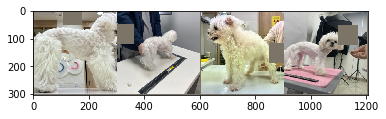

In [30]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, class_ ,file = next(iter(train_dataloader))
# inputs, classes = train_datasets[0]

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
#     preds_val=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     print(outputs.shape)
                    _, preds = torch.max(outputs.data, dim= 1)
#                     print(preds)
#                     if phase=='val' and epoch==24:
# #                         print('val')
#                         preds_val.extend(list(preds.data.detach().cpu().numpy()))
            
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 레즈넷50, 파인튜닝,exponential warmup, lr = 0.001

In [48]:
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_resnet50.fc = nn.Linear(num_ftrs, 9)

model_resnet50 = model_resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.9)

In [49]:
model_resnet50,  preds_val, preds_train = train_model(model_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6530 Acc: 0.3585
val Loss: 5.3805 Acc: 0.4131

Epoch 1/24
----------
train Loss: 1.2686 Acc: 0.4975
val Loss: 4.7724 Acc: 0.3048

Epoch 2/24
----------
train Loss: 1.0584 Acc: 0.5982
val Loss: 1.9683 Acc: 0.3023

Epoch 3/24
----------
train Loss: 0.7928 Acc: 0.7140
val Loss: 2.1727 Acc: 0.3476

Epoch 4/24
----------
train Loss: 0.5801 Acc: 0.7936
val Loss: 3.5284 Acc: 0.3275

Epoch 5/24
----------
train Loss: 0.4298 Acc: 0.8439
val Loss: 2.7932 Acc: 0.2872

Epoch 6/24
----------
train Loss: 0.2475 Acc: 0.9275
val Loss: 3.0697 Acc: 0.2922

Epoch 7/24
----------
train Loss: 0.1337 Acc: 0.9547
val Loss: 2.7264 Acc: 0.3426

Epoch 8/24
----------
train Loss: 0.1319 Acc: 0.9507
val Loss: 3.5905 Acc: 0.3073

Epoch 9/24
----------
train Loss: 0.1082 Acc: 0.9637
val Loss: 3.1511 Acc: 0.2947

Epoch 10/24
----------
train Loss: 0.0547 Acc: 0.9869
val Loss: 3.2353 Acc: 0.3249

Epoch 11/24
----------
train Loss: 0.0404 Acc: 0.9879
val Loss: 3.4444 Acc: 0.3123

Ep

## 레즈넷50, 파인튜닝,exponential warmup, lr = 0.0025

In [53]:
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_resnet50.fc = nn.Linear(num_ftrs, 9)

model_resnet50 = model_resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.0025)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.9)

model_resnet50,  preds_val, preds_train = train_model(model_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9248 Acc: 0.3182
val Loss: 15316.3617 Acc: 0.4131

Epoch 1/24
----------
train Loss: 1.6991 Acc: 0.3343
val Loss: 17.2852 Acc: 0.1990

Epoch 2/24
----------
train Loss: 1.6630 Acc: 0.3343
val Loss: 1.5577 Acc: 0.4131

Epoch 3/24
----------
train Loss: 1.5967 Acc: 0.3434
val Loss: 9.3513 Acc: 0.3929

Epoch 4/24
----------
train Loss: 1.6241 Acc: 0.3303
val Loss: 1.7892 Acc: 0.3929

Epoch 5/24
----------
train Loss: 1.5409 Acc: 0.3484
val Loss: 1.8365 Acc: 0.3249

Epoch 6/24
----------
train Loss: 1.5671 Acc: 0.3525
val Loss: 1.6468 Acc: 0.3224

Epoch 7/24
----------
train Loss: 1.5318 Acc: 0.3686
val Loss: 4.1869 Acc: 0.2519

Epoch 8/24
----------
train Loss: 1.5493 Acc: 0.3243
val Loss: 4.1612 Acc: 0.3249

Epoch 9/24
----------
train Loss: 1.5111 Acc: 0.3766
val Loss: 1.6653 Acc: 0.2620

Epoch 10/24
----------
train Loss: 1.4998 Acc: 0.3787
val Loss: 1.6533 Acc: 0.2997

Epoch 11/24
----------
train Loss: 1.4871 Acc: 0.3897
val Loss: 1.6728 Acc: 0.234

KeyboardInterrupt: 

## 레즈넷34, 트랜스퍼러닝 ,Exp, lr = 0.001

In [129]:
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_resnet50.fc = nn.Linear(num_ftrs, 9)


params_to_update = []
update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_resnet34.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else :
        param.requires_grad = False
        
model_resnet34 = model_resnet34.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.001)


exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)
model_resnet34, preds_val, preds_train  = train_model(model_resnet34, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

fc.weight
fc.bias
Epoch 0/24
----------
train Loss: 1.7934 Acc: 0.2975
val Loss: 1.5335 Acc: 0.2955

Epoch 1/24
----------
train Loss: 1.5858 Acc: 0.3472
val Loss: 1.5081 Acc: 0.3523

Epoch 2/24
----------
train Loss: 1.4719 Acc: 0.3934
val Loss: 1.5231 Acc: 0.3220

Epoch 3/24
----------
train Loss: 1.4166 Acc: 0.4281
val Loss: 1.5150 Acc: 0.3220

Epoch 4/24
----------
train Loss: 1.3581 Acc: 0.4485
val Loss: 1.5333 Acc: 0.3030

Epoch 5/24
----------
train Loss: 1.3055 Acc: 0.4787
val Loss: 1.5958 Acc: 0.2841

Epoch 6/24
----------
train Loss: 1.2915 Acc: 0.4751
val Loss: 1.5771 Acc: 0.2765

Epoch 7/24
----------
train Loss: 1.2469 Acc: 0.4956
val Loss: 1.5764 Acc: 0.2917

Epoch 8/24
----------
train Loss: 1.2321 Acc: 0.4893
val Loss: 1.5697 Acc: 0.2803

Epoch 9/24
----------
train Loss: 1.2176 Acc: 0.4947
val Loss: 1.5822 Acc: 0.2727

Epoch 10/24
----------
train Loss: 1.1786 Acc: 0.5107
val Loss: 1.5880 Acc: 0.2841

Epoch 11/24
----------
train Loss: 1.1653 Acc: 0.5222
val Loss: 1.65

In [64]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
for param in model_ft.parameters():
    param.requires_grad_(False)

model_ft.fc = nn.Linear(num_ftrs, 9)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
# exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)
scheduler = CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

NameError: name 'CosineAnnealingLR' is not defined

In [78]:
model_vgg = models.vgg16(pretrained=True)
num_ftrs = model_vgg.classifier[6].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_vgg.classifier[6] = nn.Linear(num_ftrs, 9)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()

params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model_vgg.named_parameters() :
#     print(name)
    if name in update_param_names : 
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else :
        param.requires_grad = False
        
print('-' * 50)
print(params_to_update)

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_vgg.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

classifier.6.weight
classifier.6.bias
--------------------------------------------------
[Parameter containing:
tensor([[-0.0111,  0.0101,  0.0156,  ...,  0.0031,  0.0126,  0.0041],
        [-0.0137, -0.0032, -0.0111,  ..., -0.0043, -0.0143, -0.0036],
        [-0.0141,  0.0004, -0.0022,  ...,  0.0130, -0.0075,  0.0058],
        ...,
        [-0.0128, -0.0028, -0.0046,  ..., -0.0073, -0.0094,  0.0030],
        [-0.0040,  0.0040, -0.0118,  ...,  0.0050,  0.0004, -0.0105],
        [-0.0069, -0.0126,  0.0087,  ..., -0.0022,  0.0024,  0.0018]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0093, -0.0021, -0.0044, -0.0015,  0.0071,  0.0100, -0.0131,  0.0088,
        -0.0002], device='cuda:0', requires_grad=True)]


In [79]:
model_ft = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7858 Acc: 0.3357
val Loss: 1.6983 Acc: 0.1818

Epoch 1/24
----------
train Loss: 1.4296 Acc: 0.4396
val Loss: 1.6410 Acc: 0.2386

Epoch 2/24
----------
train Loss: 1.2837 Acc: 0.4929
val Loss: 1.6570 Acc: 0.2197

Epoch 3/24
----------
train Loss: 1.2554 Acc: 0.4858
val Loss: 1.7418 Acc: 0.2159

Epoch 4/24
----------
train Loss: 1.1486 Acc: 0.5311
val Loss: 1.6820 Acc: 0.2462

Epoch 5/24
----------
train Loss: 1.1059 Acc: 0.5524
val Loss: 1.7319 Acc: 0.2273

Epoch 6/24
----------
train Loss: 1.1371 Acc: 0.5533
val Loss: 1.7505 Acc: 0.2386

Epoch 7/24
----------
train Loss: 1.0603 Acc: 0.5737
val Loss: 1.7027 Acc: 0.2273

Epoch 8/24
----------
train Loss: 1.0859 Acc: 0.5568
val Loss: 1.7149 Acc: 0.2462

Epoch 9/24
----------
train Loss: 1.0275 Acc: 0.5826
val Loss: 1.6572 Acc: 0.2386

Epoch 10/24
----------
train Loss: 1.0065 Acc: 0.6092
val Loss: 1.6883 Acc: 0.2576

Epoch 11/24
----------
train Loss: 0.9809 Acc: 0.6190
val Loss: 1.6844 Acc: 0.2652

Ep

In [ ]:
EfficientNet.from_pretrained('efficientnet-b0', in_channels=in_channels)

In [75]:
model_effi = EfficientNet.from_pretrained('efficientnet-b0', in_channels=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/jh20/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [80]:
num_ftrs = model_effi._fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_effi._fc = nn.Linear(num_ftrs, 9)

model_effi = model_effi.to(device)

criterion = nn.CrossEntropyLoss()

# params_to_update = []
# update_param_names = ['classifier.6.weight', 'classifier.6.bias']
# for name, param in model_vgg.named_parameters() :
# #     print(name)
#     if name in update_param_names : 
#         param.requires_grad = True
#         params_to_update.append(param)
#         print(name)
#     else :
#         param.requires_grad = False
        
# print('-' * 50)
# print(params_to_update)

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_effi.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

In [81]:
model_train = train_model(model_effi, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4882 Acc: 0.4458
val Loss: 2.0298 Acc: 0.1932

Epoch 1/24
----------
train Loss: 0.6584 Acc: 0.7904
val Loss: 3.2297 Acc: 0.1667

Epoch 2/24
----------
train Loss: 0.3071 Acc: 0.9059
val Loss: 2.9464 Acc: 0.3485

Epoch 3/24
----------
train Loss: 0.2306 Acc: 0.9218
val Loss: 4.0073 Acc: 0.3674

Epoch 4/24
----------
train Loss: 0.1579 Acc: 0.9512
val Loss: 3.9279 Acc: 0.3106

Epoch 5/24
----------
train Loss: 0.1648 Acc: 0.9512
val Loss: 4.1261 Acc: 0.2803

Epoch 6/24
----------
train Loss: 0.1381 Acc: 0.9565
val Loss: 4.0753 Acc: 0.2917

Epoch 7/24
----------
train Loss: 0.0909 Acc: 0.9698
val Loss: 4.1342 Acc: 0.2917

Epoch 8/24
----------
train Loss: 0.0670 Acc: 0.9805
val Loss: 3.9444 Acc: 0.3030

Epoch 9/24
----------
train Loss: 0.0933 Acc: 0.9698
val Loss: 4.2650 Acc: 0.3371

Epoch 10/24
----------
train Loss: 0.0658 Acc: 0.9796
val Loss: 4.3070 Acc: 0.3295

Epoch 11/24
----------
train Loss: 0.0511 Acc: 0.9813
val Loss: 3.9340 Acc: 0.3144

Ep

In [92]:
model_alexnet = models.alexnet(pretrained=True)

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs,9)

model_alexnet = model_alexnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_alexnet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

model_train = train_model(model_alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.0355 Acc: 0.2487
val Loss: 1.5867 Acc: 0.4131

Epoch 1/24
----------
train Loss: 1.6708 Acc: 0.3364
val Loss: 1.6039 Acc: 0.4131

Epoch 2/24
----------
train Loss: 1.6393 Acc: 0.3243
val Loss: 1.5690 Acc: 0.4131

Epoch 3/24
----------
train Loss: 1.6304 Acc: 0.3364
val Loss: 1.5620 Acc: 0.4131

Epoch 4/24
----------
train Loss: 1.6384 Acc: 0.3424
val Loss: 1.5423 Acc: 0.4131

Epoch 5/24
----------
train Loss: 1.6294 Acc: 0.3424
val Loss: 1.5545 Acc: 0.4131

Epoch 6/24
----------
train Loss: 1.6338 Acc: 0.3424


KeyboardInterrupt: 

In [27]:
model_incep

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [37]:
model_incep = models.inception_v3(pretrained=True)
# num_ftrs = model_incep.AuxLogits.fc.in_features
# model_incep.AuxLogits.fc = nn.Linear(num_ftrs, 9)

model_incep.aux_logits = False
num_ftrs = model_incep.fc.in_features
model_incep.fc = nn.Linear(num_ftrs,9)

model_incep = model_incep.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_incep.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

model_incep = train_model(model_incep, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7095 Acc: 0.2800
val Loss: 1.5263 Acc: 0.4081

Epoch 1/24
----------
train Loss: 1.6759 Acc: 0.3273
val Loss: 4.7952 Acc: 0.4030

Epoch 2/24
----------
train Loss: 1.6666 Acc: 0.3122
val Loss: 1.5291 Acc: 0.4081

Epoch 3/24
----------
train Loss: 1.6626 Acc: 0.3212
val Loss: 2.0559 Acc: 0.3728

Epoch 4/24
----------
train Loss: 1.6575 Acc: 0.3313
val Loss: 1.5634 Acc: 0.3854

Epoch 5/24
----------
train Loss: 1.6585 Acc: 0.3192
val Loss: 2.0181 Acc: 0.3678

Epoch 6/24
----------
train Loss: 1.6491 Acc: 0.3253
val Loss: 3.7068 Acc: 0.1688

Epoch 7/24
----------
train Loss: 1.6516 Acc: 0.3283
val Loss: 1.5669 Acc: 0.4081

Epoch 8/24
----------
train Loss: 1.6543 Acc: 0.3343
val Loss: 1.4922 Acc: 0.4106

Epoch 9/24
----------
train Loss: 1.6542 Acc: 0.3233
val Loss: 2.0171 Acc: 0.4181

Epoch 10/24
----------
train Loss: 1.6363 Acc: 0.3223
val Loss: 1.7710 Acc: 0.4055

Epoch 11/24
----------
train Loss: 1.6423 Acc: 0.3263
val Loss: 1.9420 Acc: 0.4106

Ep

In [32]:
model_incep

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [31]:
i

tensor([1, 1])

In [49]:
x = torch.randn((1,3, 299,299))

In [50]:
x.shape

torch.Size([1, 3, 299, 299])

In [38]:
x = torch.tensor(x,dtype=torch.float32)

/home/jh20/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [40]:
model_incep1 = models.inception_v3(pretrained=True)

In [53]:
model_incep1.eval()
model_incep1(x).shape

torch.Size([1, 1000])

In [42]:
model_incep1

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri